# EDA

1. 전체적인 데이터 분석
- 분석의 목적과 목적에 맞는 변수가 무엇인지
- 데이터형 확인/데이터의 오류나 누락이 없는지
- 데이터를 구성하는 각 속성값이 예측한 범위와 분포를 갖는지 -> 아니라면 그 이유가 무엇인지 확인

2. 데이터의 개별 속성값 관찰
- 개별 데이터를 관찰하며 전체적인 추세와 특이사항 관찰
- 적절한 요약통계 지표 사용 (평균, 중앙값, 분산 등)
- 시각화를 통해 데이터의 개별 속성에 어떤 통계 지표가 적절한지 결정

3. 속성 간의 관계 분석
- 개별 속성 관찰에서 찾아내지 못했던 속성들의 조합, 패턴 발견
- 그래프를 통해 시각화하여 속성 간의 관계 분석
- 상관계수를 통한 상관관계 확인

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv('../data/train.csv').drop(columns=['ID'])
df = train.copy()
train_X = train.drop(columns=['y'])
train_y = train['y']

In [43]:
len(df)

40118

In [44]:
# import pandas as pd
# import numpy as np

# from imbens.sampler import ADASYN
# # Create a sample DataFrame (for demonstration purposes)
# np.random.seed(42)
# df = pd.DataFrame({
#     'feature1': np.random.randn(100),
#     'feature2': np.random.randn(100),
#     'y': np.random.randn(100) * 100  # Continuous target variable
# })

# # Split features and target
# X = df.drop(columns=['y'])
# y = df['y']

# # Initialize SMOGN sampler
# smogn = ADASYN(random_state=42)

# # Apply SMOGN to the dataset
# X_res, y_res = smogn.fit_resample(X, y)

# # Combine the resampled data back into a DataFrame
# df_resampled = pd.concat([X_res, y_res], axis=1)

# print("Original Data Distribution:")
# print(y.describe())

# print("\nResampled Data Distribution:")
# print(y_res.describe())


In [45]:
import numpy as np
from imbens.sampler import RandomUnderSampler, RandomOverSampler
from imbens.sampler import SMOTE


In [46]:
print(len(df))

40118


In [47]:
import pandas as pd
import numpy as np
from imbens.sampler import RandomUnderSampler

def undersample_small_y(df, target_col='y', quantile=0.90, sampling_strategy=0.5):
    """
    Undersamples the smaller y values based on a specified quantile for regression.

    Parameters:
    df (pd.DataFrame): Input dataframe containing features and target.
    target_col (str): Name of the target column. Default is 'y'.
    quantile (float): Quantile below which y values will be undersampled. Default is 0.25.
    sampling_strategy (float): Ratio of the number of samples after resampling. Default is 0.5.

    Returns:
    pd.DataFrame: Dataframe with undersampled small y values and original large y values.
    """
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    # Define the threshold for small y values
    threshold = y.quantile(quantile)
    
    # Bin y values into categories
    y_binned = np.where(y < threshold, 0, 1)
    
    # Combine X and y into a single DataFrame for resampling
    df_combined = pd.concat([X, y], axis=1)
    
    # Apply undersampling to the binned categories
    undersample = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
    df_res, y_res_binned = undersample.fit_resample(df_combined, y_binned)
    
    return df_res




In [48]:
import pandas as pd
import numpy as np
from imbens.sampler import RandomOverSampler

def oversample_large_y(df, target_col='y', quantile=0.90, sampling_strategy=0.5):
    """
    Oversamples the larger y values based on a specified quantile for regression.

    Parameters:
    df (pd.DataFrame): Input dataframe containing features and target.
    target_col (str): Name of the target column. Default is 'y'.
    quantile (float): Quantile above which y values will be oversampled. Default is 0.75.
    sampling_strategy (float): Ratio of the number of samples after resampling. Default is 0.5.

    Returns:
    pd.DataFrame: Dataframe with oversampled large y values and original small y values.
    """
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    # Define the threshold for large y values
    threshold = y.quantile(quantile)
    
    # Bin y values into categories
    y_binned = np.where(y >= threshold, 1, 0)
    
    # Combine X and y into a single DataFrame for resampling
    df_combined = pd.concat([X, y], axis=1)
    
    # Apply oversampling to the binned categories
    oversample = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)
    df_res, y_res_binned = oversample.fit_resample(df_combined, y_binned)
    
    return df_res


In [49]:

# Example usage
oversampled_df = oversample_large_y(df, target_col='y', quantile=0.90, sampling_strategy=0.5)
len(oversampled_df)

54159

In [50]:

train = undersample_small_y(oversampled_df, target_col='y', quantile=0.90, sampling_strategy=0.5)

print(len(train))

train.to_csv('../data/train_resampled.csv', index=False)

16248


In [51]:

def apply_smogn(df, target_col='y', k_neighbors=5, tr=0.5, th=0.5, random_state=42):
    """
    Applies SMOGN (Synthetic Minority Over-sampling Technique for Regression) to a given dataframe.

    Parameters:
    df (pd.DataFrame): Input dataframe containing features and target.
    target_col (str): Name of the target column. Default is 'y'.
    k_neighbors (int): Number of nearest neighbors for generating synthetic samples. Default is 5.
    tr (float): Threshold ratio to identify minority regions. Default is 0.5.
    th (float): Threshold for the local density of synthetic samples. Default is 0.5.
    random_state (int): Random state for reproducibility. Default is 42.

    Returns:
    pd.DataFrame: Resampled dataframe with synthetic data generated by SMOGN.
    """
    # Split features and target
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Initialize SMOGN sampler with provided parameters
    smogn = SMOTE(k_neighbors=k_neighbors, tr=tr, th=th, random_state=random_state)

    # Apply SMOGN to the dataset
    X_res, y_res = smogn.fit_resample(X, y)

    # Combine the resampled data back into a DataFrame
    df_resampled = pd.concat([X_res, y_res], axis=1)

    return df_resampled


In [52]:
print(df['y'].value_counts())


y
83.956873    3
83.165698    3
83.559094    3
81.858722    3
82.398395    3
            ..
82.992560    1
80.454199    1
84.428375    1
80.941699    1
86.192975    1
Name: count, Length: 39540, dtype: int64


## 1. 전체적인 데이터 분석

In [53]:
print('데이터 정보')
train.info()

print('기본 통계량')
train.describe()

데이터 정보
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16248 entries, 0 to 16247
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x_0     16248 non-null  float64
 1   x_1     16248 non-null  float64
 2   x_2     16248 non-null  float64
 3   x_3     16248 non-null  float64
 4   x_4     16248 non-null  float64
 5   x_5     16248 non-null  float64
 6   x_6     16248 non-null  float64
 7   x_7     16248 non-null  float64
 8   x_8     16248 non-null  float64
 9   x_9     16248 non-null  float64
 10  x_10    16248 non-null  float64
 11  y       16248 non-null  float64
dtypes: float64(12)
memory usage: 1.5 MB
기본 통계량


x_0           x_1           x_2           x_3           x_4  \
count  16248.000000  16248.000000  16248.000000  16248.000000  16248.000000   
mean       1.010654     -1.876726      1.190083      0.897655     -0.326616   
std        0.054953      0.461113      0.041974      0.049629      0.079177   
min        0.907816     -2.546977      1.056123      0.744255     -0.577355   
25%        0.962870     -2.352211      1.160520      0.863981     -0.378289   
50%        1.010490     -1.875259      1.199027      0.914458     -0.292952   
75%        1.058746     -1.452883      1.225378      0.935590     -0.262416   
max        1.112796     -0.974175      1.253528      0.964632     -0.243309   

                x_5           x_6           x_7           x_8           x_9  \
count  16248.000000  16248.000000  16248.000000  16248.000000  16248.000000   
mean      -1.725139      0.497039     -0.133741      0.622888      0.327741   
std        0.076110      0.024417      0.048984      0.044203      0.056091   
min       -1.817143      0.463858     -0.231286      0.575064      0.222945   
25%       -1.794256      0.477508     -0.178544      0.582709      0.275918   
50%       -1.748087      0.493526     -0.126651      0.603104      0.337080   
75%       -1.661631      0.506984     -0.088401      0.669734      0.376624   
max       -1.545635      0.584193     -0.055259      0.699862      0.428239   

               x_10             y  
count  16248.000000  16248.000000  
mean       0.050068     87.099613  
std        0.042005      4.671391  
min       -0.059269     16.677906  
25%        0.016590     83.063744  
50%        0.062489     86.601140  
75%        0.088154     91.525163  
max        0.097734     95.296179

In [54]:
train[1:2]

x_0       x_1       x_2       x_3       x_4       x_5      x_6  \
1  1.013419 -1.632471  1.203114  0.931963 -0.321845 -1.713794  0.48213   

        x_7       x_8       x_9    x_10          y  
1 -0.104905  0.588446  0.356199  0.0409  86.538232

In [55]:
print('결측치 확인')
train.isnull()

print('데이터 형식')
train.dtypes

결측치 확인
데이터 형식


x_0     float64
x_1     float64
x_2     float64
x_3     float64
x_4     float64
x_5     float64
x_6     float64
x_7     float64
x_8     float64
x_9     float64
x_10    float64
y       float64
dtype: object

## 2. 데이터 개별의 속성값 관찰

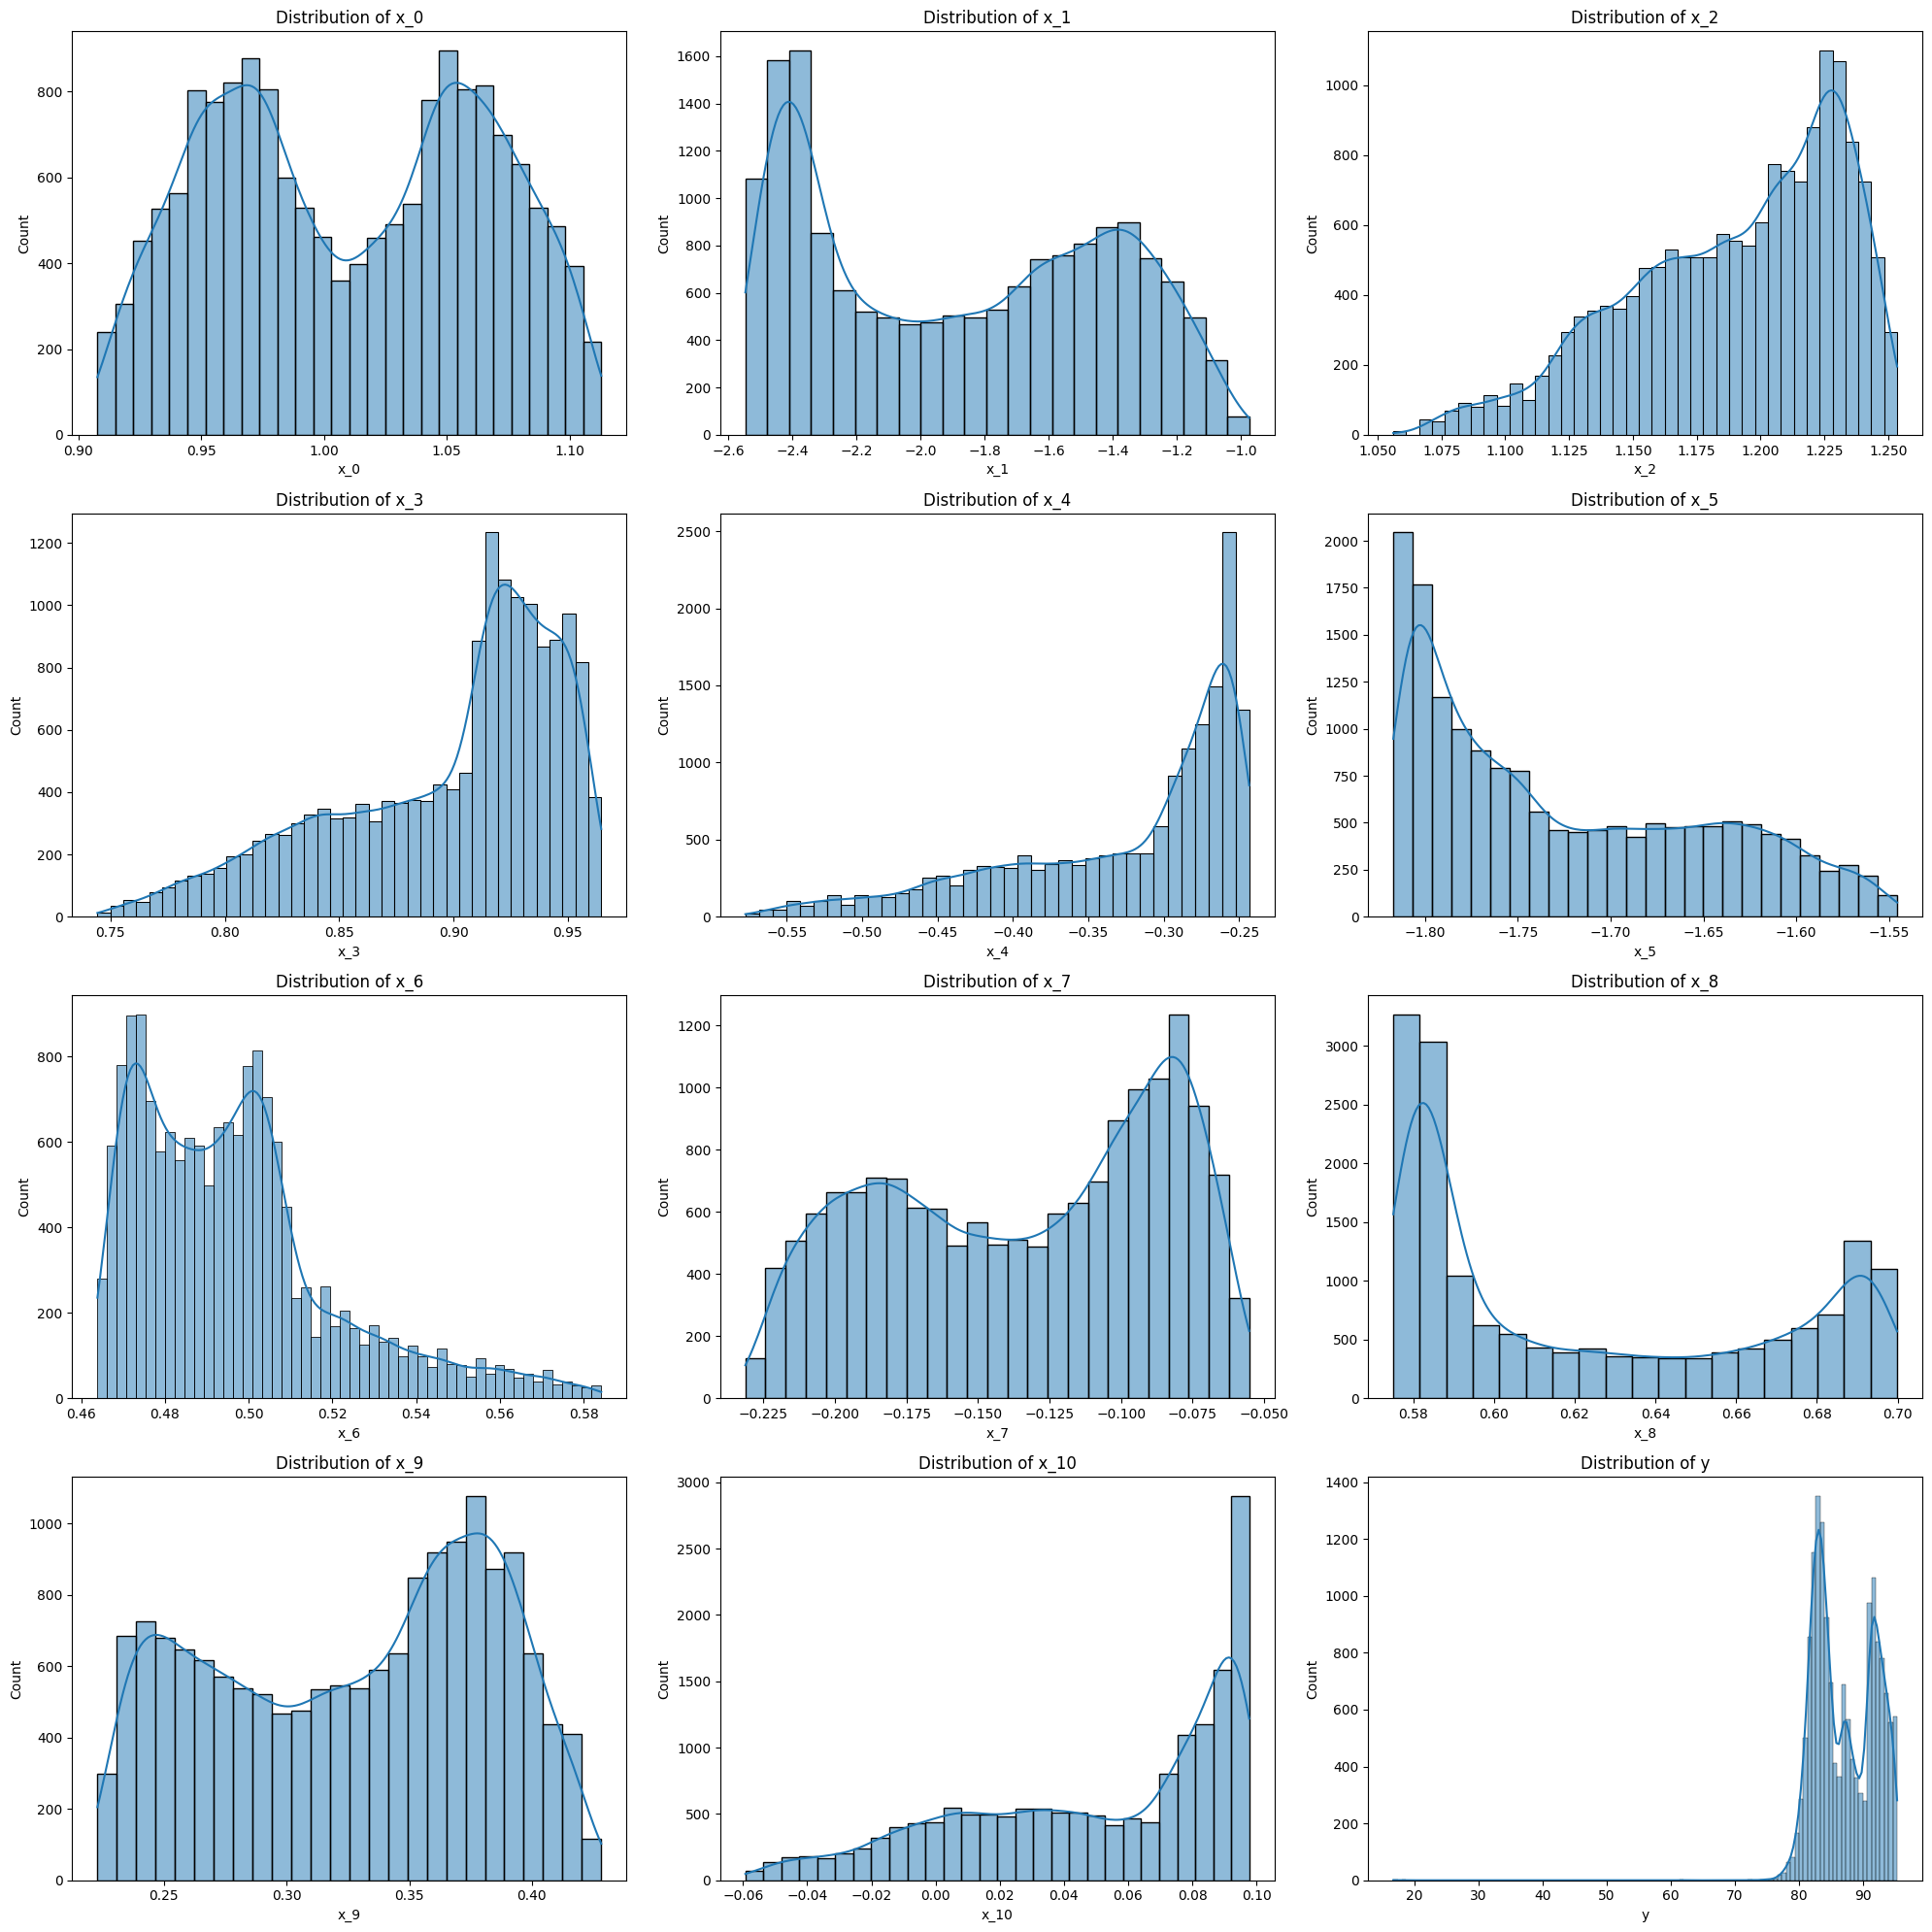

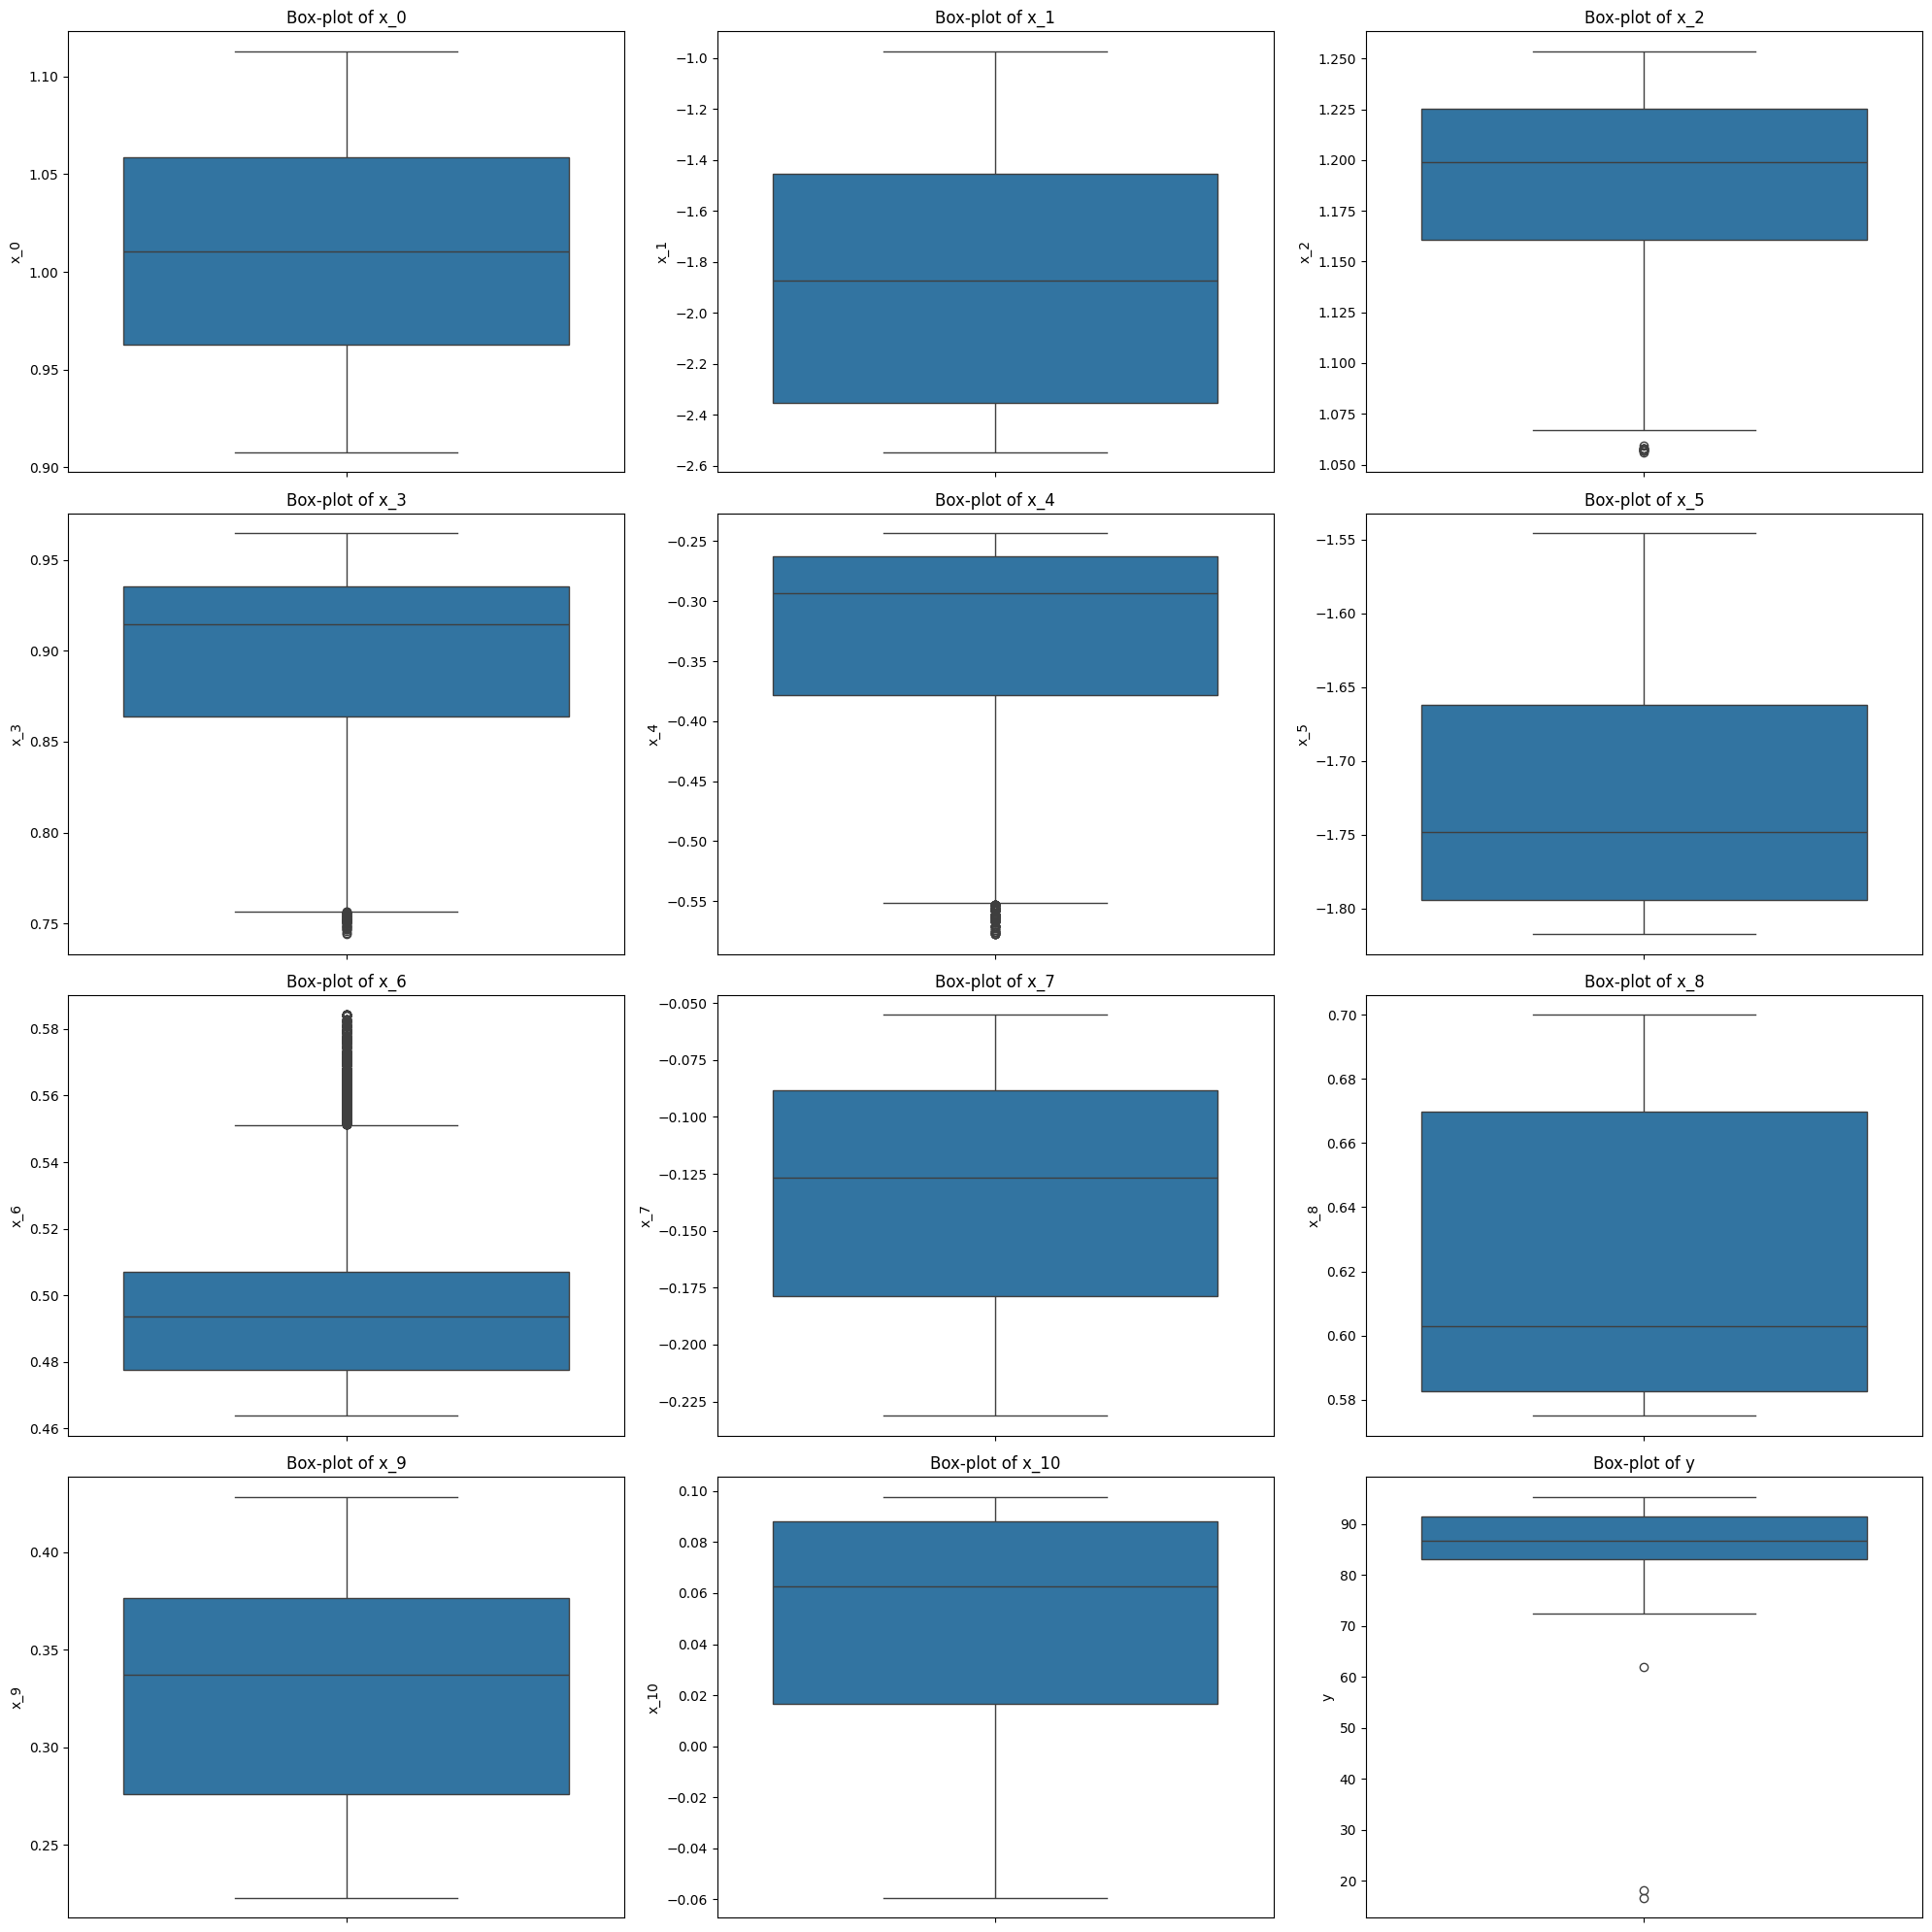

In [56]:
# create histograms for each variables
fig,axes = plt.subplots(4,3,figsize=(20,20))
axes = axes.ravel() #  Converts a two-dimensional array to a one-dimensional array

for i, col in enumerate(train):
    sns.histplot(train[col], ax= axes[i], kde=True)
    axes[i].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()
  
# create box-plots for each variable
fig,axes = plt.subplots(4,3,figsize=(20,20))
axes = axes.ravel()

for i, col in enumerate(train):
    sns.boxplot(y=train[col], ax= axes[i])
    axes[i].set_title(f'Box-plot of {col}')
    
plt.tight_layout()
plt.show()

NameError: name 'filtered_df' is not defined

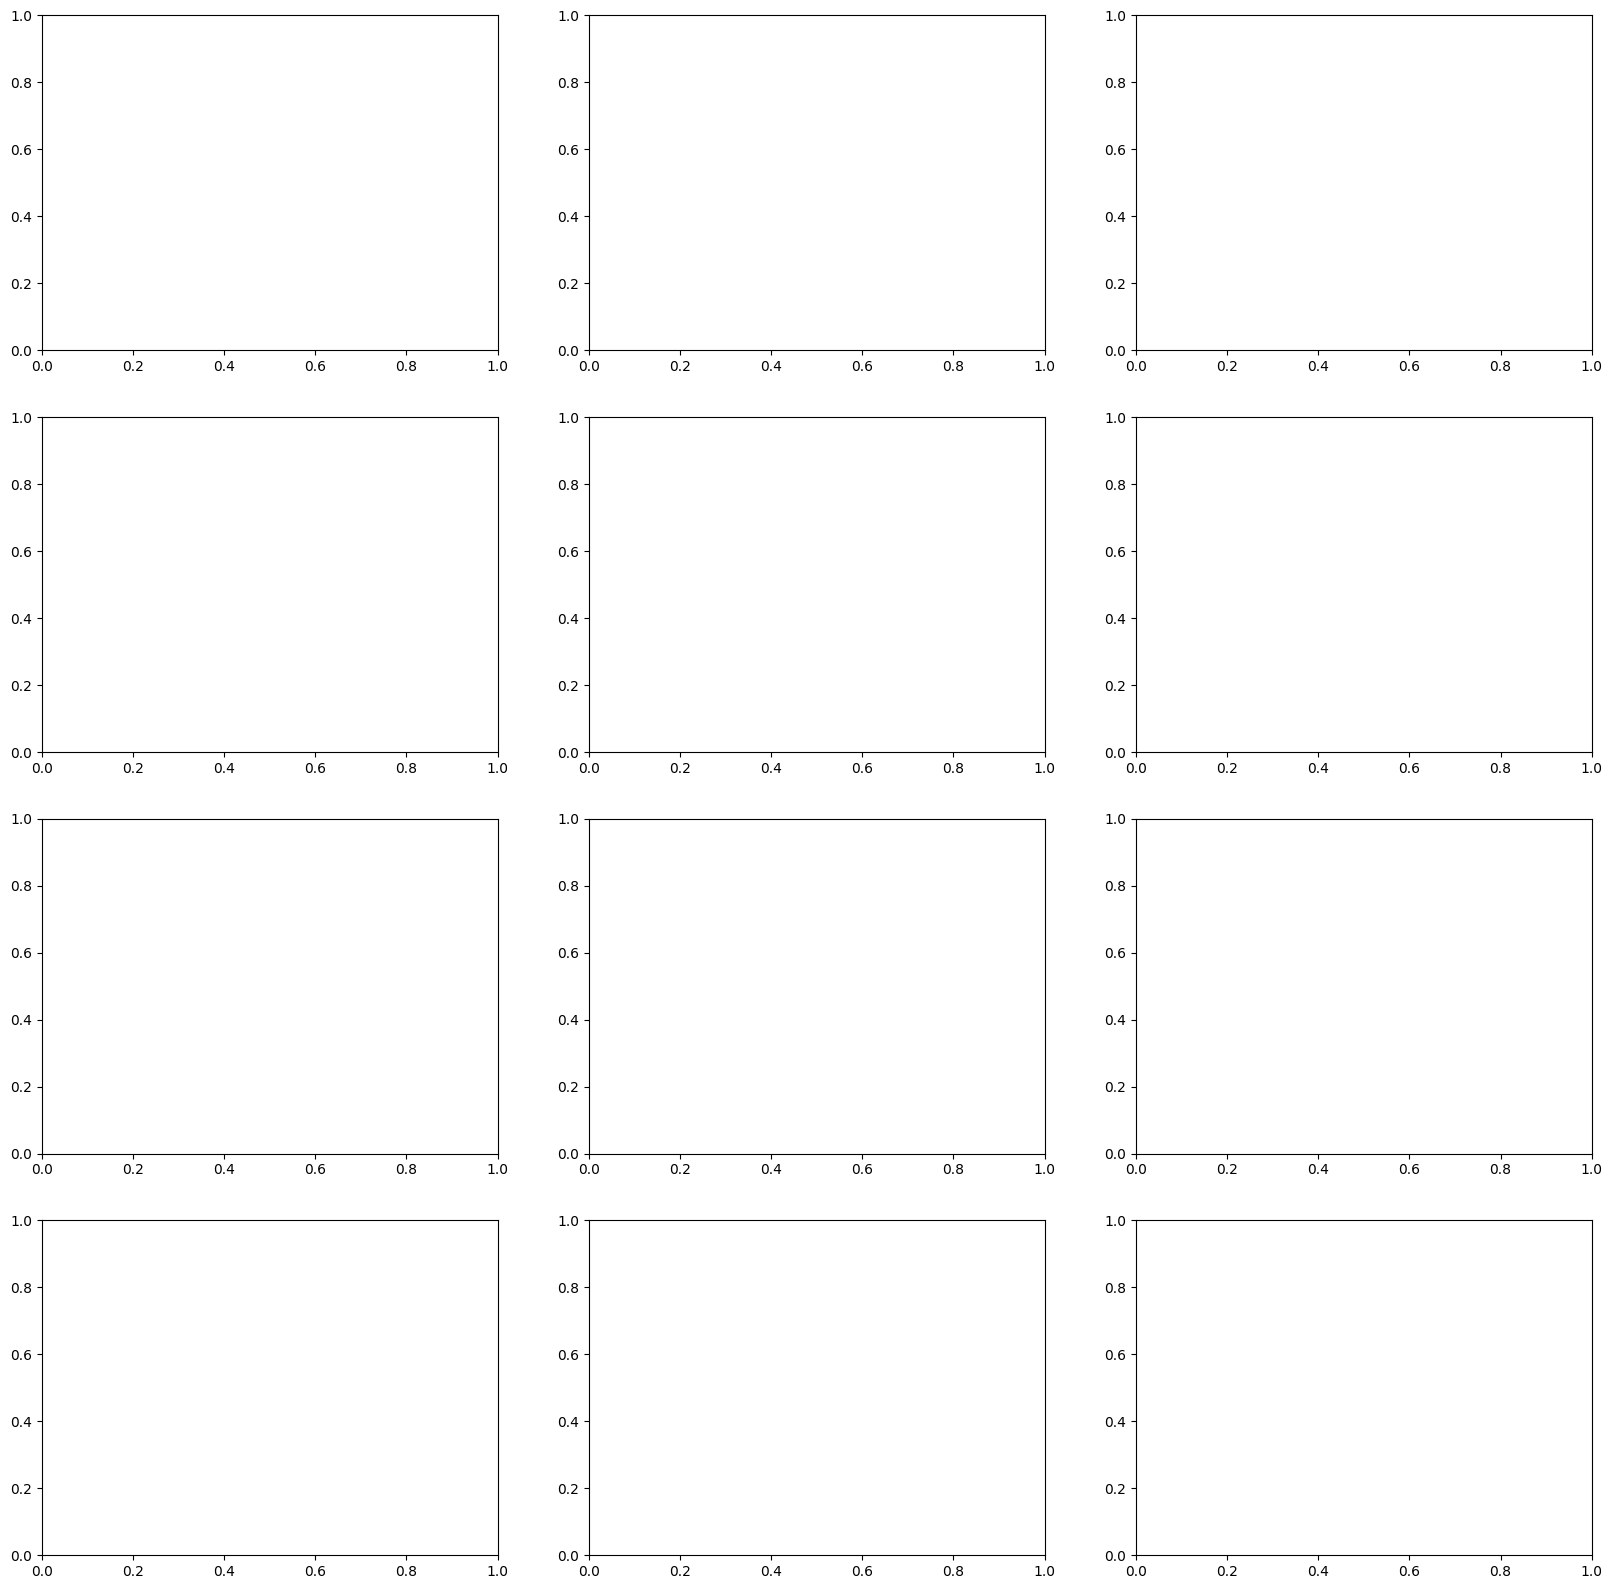

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'filtered_df' is the DataFrame where 'y' is in the upper 25 percent

# Create histograms for each variable in filtered_df
fig, axes = plt.subplots(4, 3, figsize=(20, 20))
axes = axes.ravel()  # Converts a two-dimensional array to a one-dimensional array

for i, col in enumerate(filtered_df.columns):
    sns.histplot(filtered_df[col], ax=axes[i], kde=True, bins=30)  # Adjust number of bins as needed
    axes[i].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

# Create box-plots for each variable in filtered_df
fig, axes = plt.subplots(4, 3, figsize=(20, 20))
axes = axes.ravel()

for i, col in enumerate(filtered_df.columns):
    sns.boxplot(y=filtered_df[col], ax=axes[i])
    axes[i].set_title(f'Box-plot of {col}')
    
plt.tight_layout()
plt.show()


## 3. 속성 간의 관계 분석 

X와 y의 상관 관계
x_10   -0.716420
x_8    -0.707139
x_0    -0.620384
x_4    -0.600099
x_6    -0.013633
x_2     0.118969
x_3     0.582873
x_5     0.609798
x_9     0.730894
x_7     0.733974
x_1     0.749408
y       1.000000
Name: y, dtype: float64


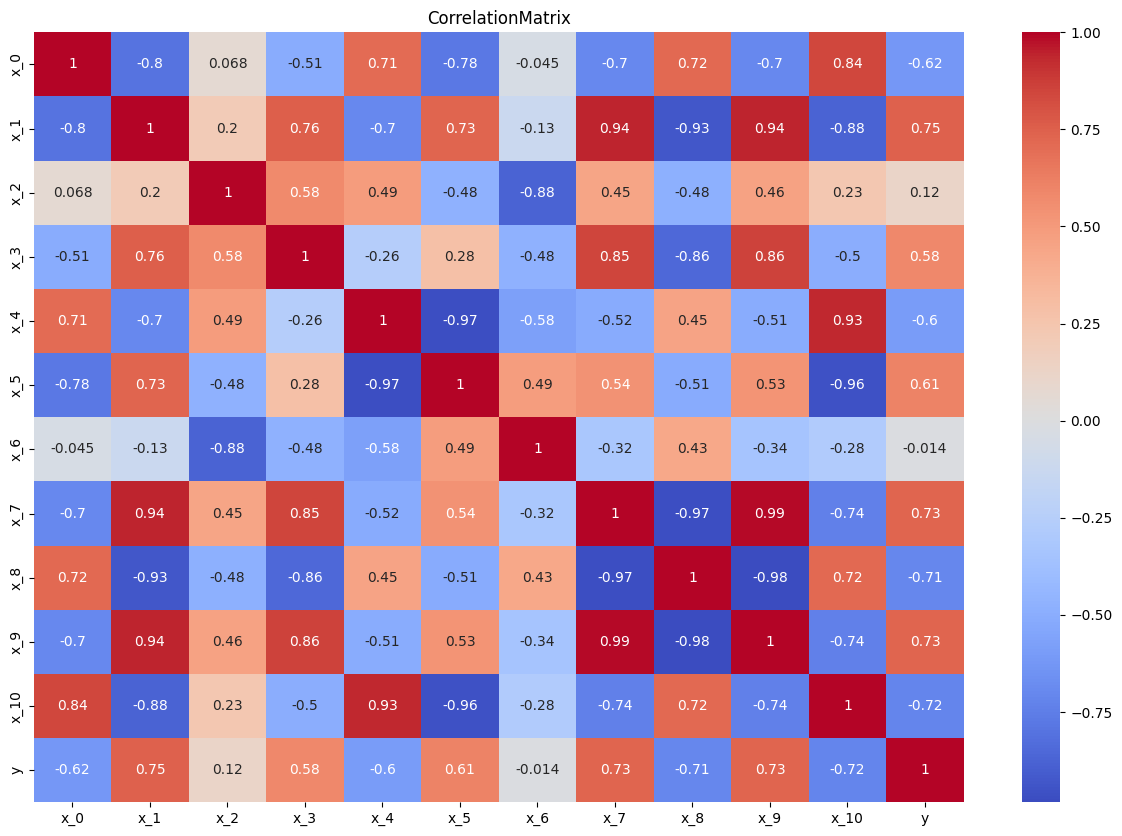

KeyboardInterrupt: 

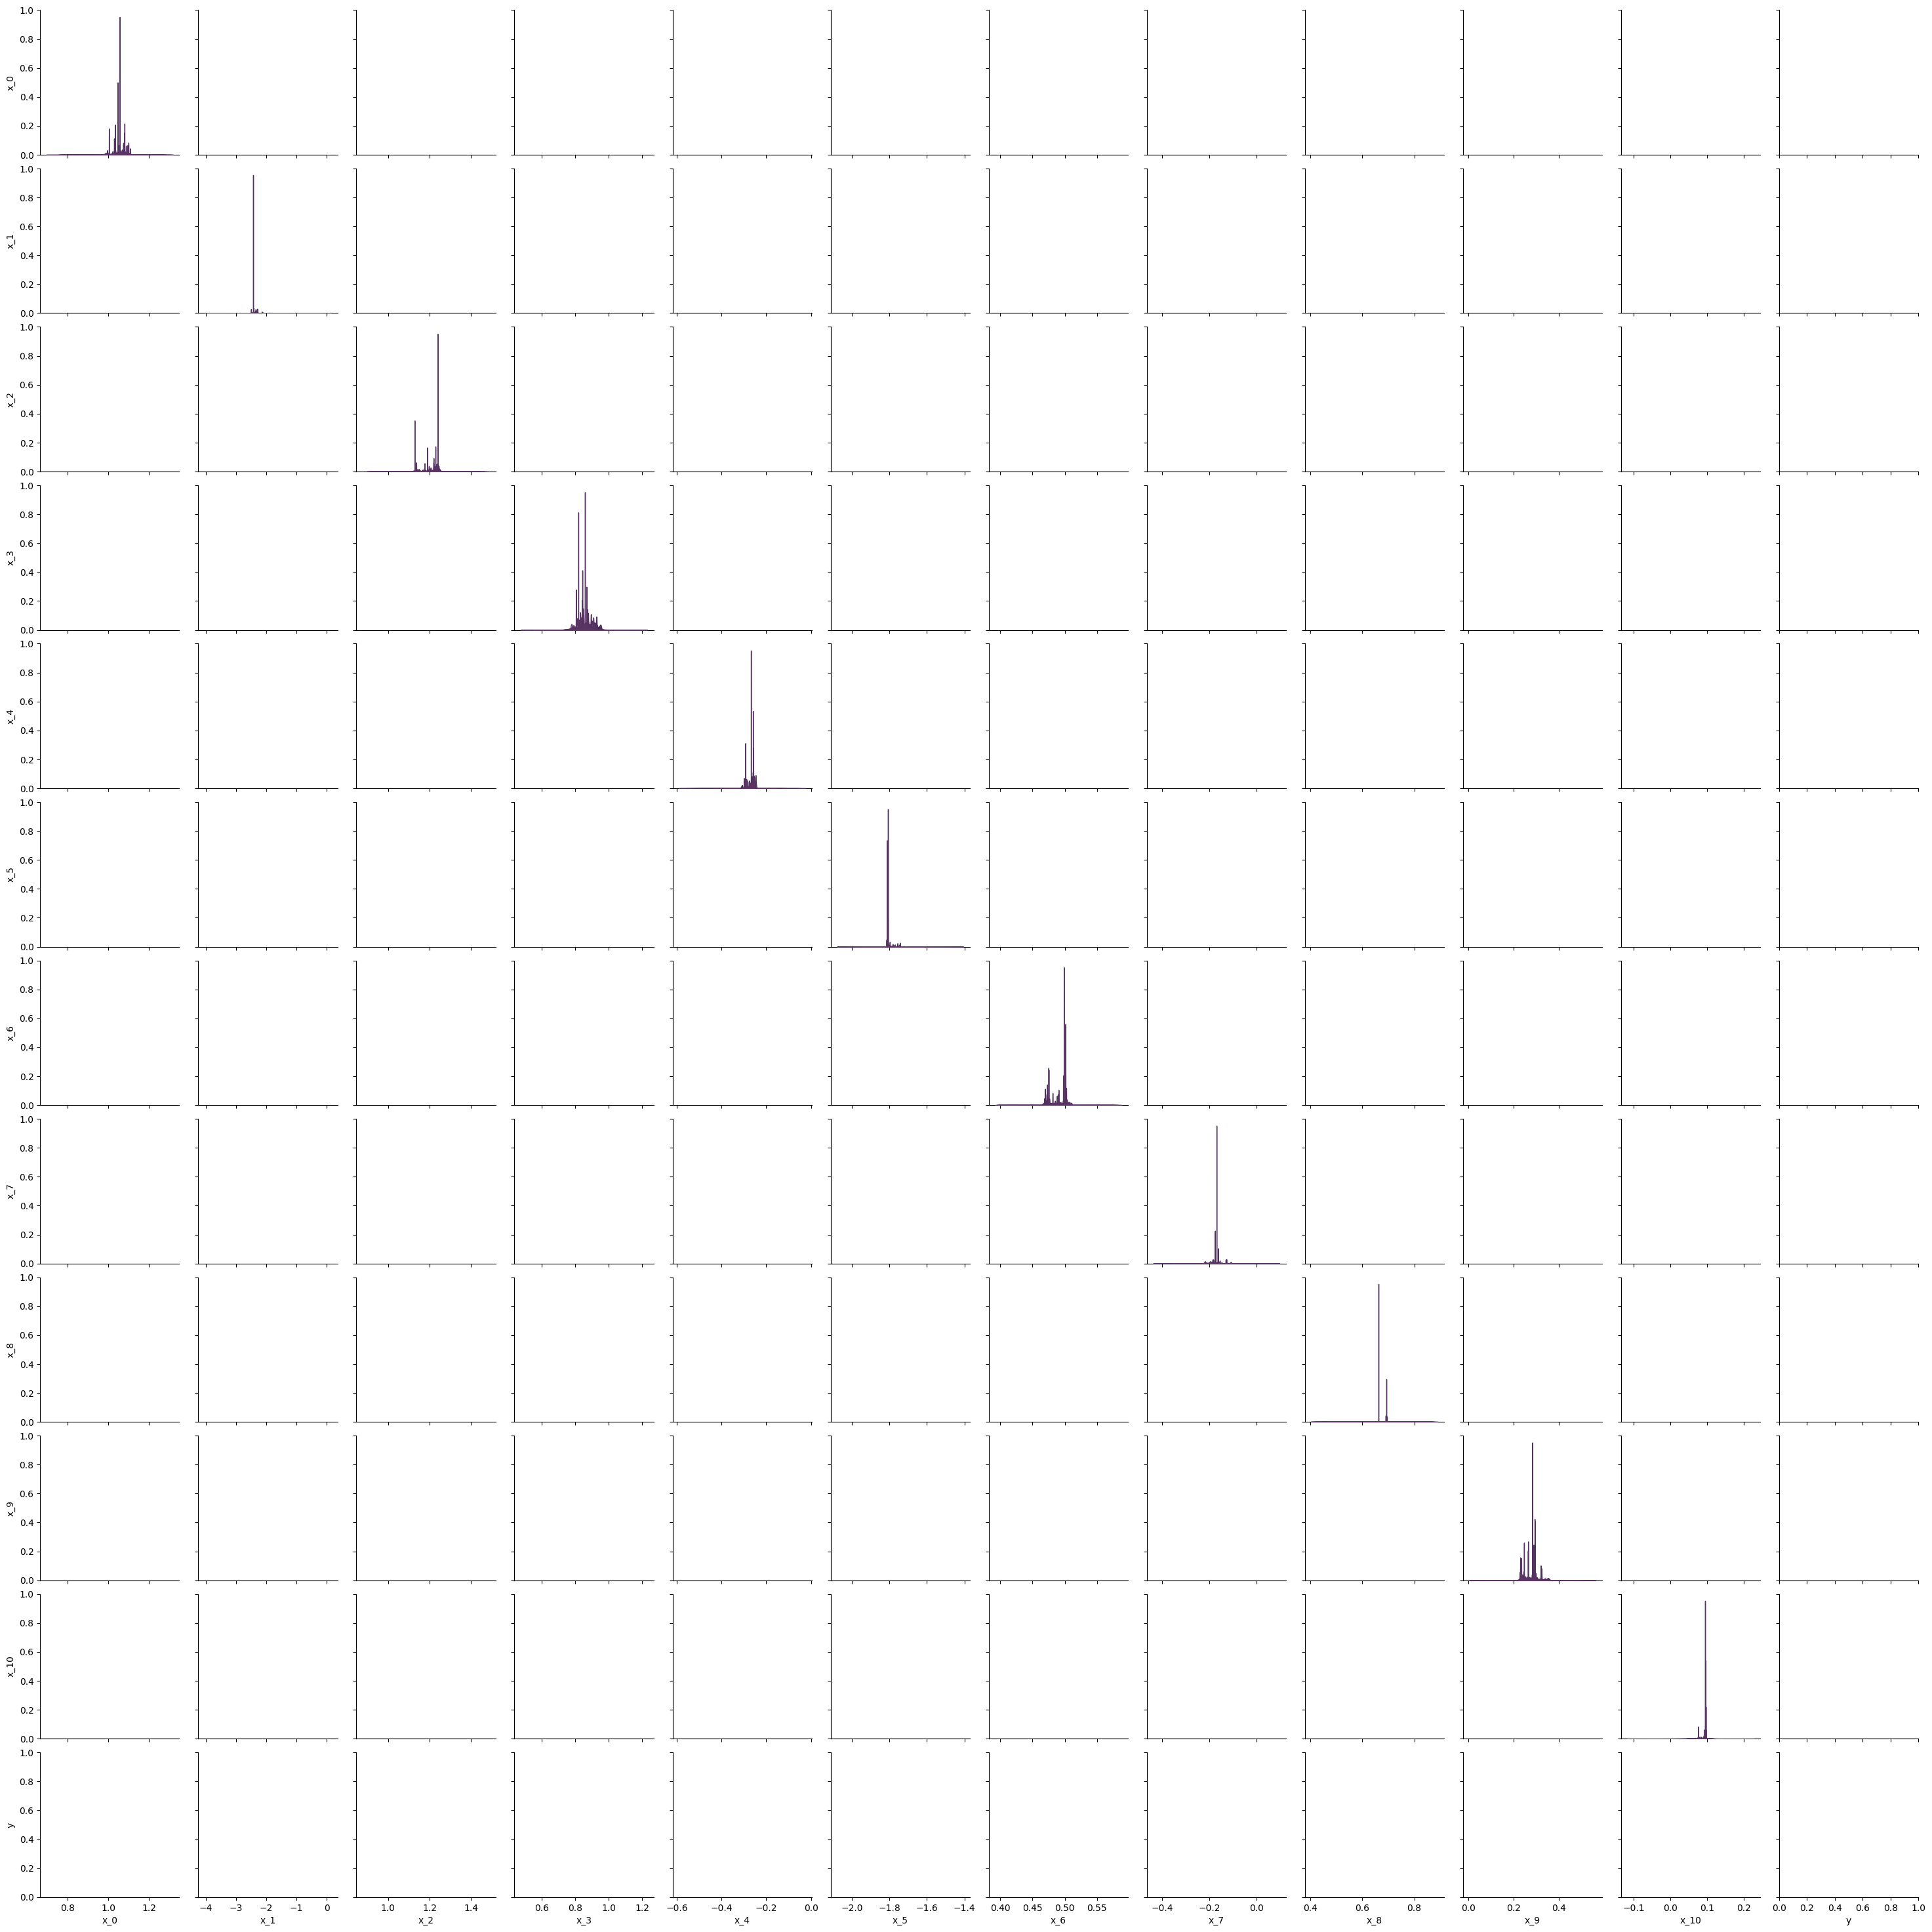

In [ ]:
# calculate the correlation matrix
corr_matrix = train.corr()
print('X와 y의 상관 관계')
print(corr_matrix['y'].sort_values(ascending=True))

# visualize the correlation matrix
plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix,annot=True,cmap='coolwarm')
plt.title('CorrelationMatrix')
plt.show()

# pairplot to visualize scatter plots betwwen 'y' and other variables
sns.pairplot(train,vars=train.columns, diag_kind='kde', kind='scatter', hue='y')
plt.show()